# Gene target analysis

Cell factory engineering strategies can be used to improve the production of progesterone in our modelled S. cerevisiae strain (iMM904_progesterone.xml).

We investigate if gene knockouts suggested in literature actually have an improving effect on the production of progesterone, and if it would be appropiate to incorporate these gene knockouts in our model.

In [18]:
# Load libraries
from cobra.io import read_sbml_model
from cameo.strain_design import OptGene
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from matplotlib import pyplot as plt
from pytest import approx
import numpy as np
import pandas as pd

### Knockout analysis

It has been suggested to knockout ERG5 and ERG6 in order to drive the flux towards the production of cholesterol instead of the natural produced steriod ergosterol (Figure 1) (Jiang, Yi-qi, and Jian-ping Lin 2022). It is from zymosterol, the knockouts should improve the flux towards cholesterol. It might improve the production of progesterone because cholesterol is an intermediate in the implemented heterologous pathway. However, it can be problematic to knockout ERG5 and ERG6 because ergosterol is an essential compound in the cellular membrane (Jordá, Tania, and Sergi Puig 2020).

![figures/3_Fig1_Steriods_ERG5_ERG6.png](figures/3_Fig1_Steriods_ERG5_ERG6.png)

Figure 1 (Jiang, Yi-qi, and Jian-ping Lin 2022)

A Synthesis of steroids. Solid arrows represent reactions validated in yeast, and dashed arrows implicate conversions catalyzed by 
unknown enzyme(s). The endogenous ergosterol pathway in yeast is highlighted in blue. The three different sheds of blue represented three modules: mevalonate (MVA) biosynthesis, farnesyl pyrophosphate (FPP) biosynthesis and ergosterol biosynthesis. Heterologous synthesis of animal-derived steroids in yeast already or potentially is highlighted in orange. Heterologous synthesis of phytosterols already or potentially in yeast is highlighted in green. The reaction catalyzed by UV-light is highlighted in yellow and common steroids involved in biotransformation is highlighted in purple. The enzymes marked in red represent the ones that require NADPH/NADP+, and the ones that require ATP are marked in purple. 

B The numbering of steroid’s carbon skeleton

We investigate the influence it has on the cell to knockout ERG5 and ERG6.

In [19]:
# Load model
model = read_sbml_model('models/iMM904_progesterone.xml')
model

Name,iMM904_progesterone
Memory address,0x07f2b33122070
Number of metabolites,1234
Number of reactions,1586
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


In [20]:
# Progesterone is released from the cell
model.add_boundary(model.metabolites.get_by_id("progesterone_c"), type="demand")

Reaction identifier,DM_progesterone_c
Name,progesterone demand
Memory address,0x07f2b33122fa0
Stoichiometry,progesterone_c --> progesterone -->
GPR,
Lower bound,0
Upper bound,1000.0


In [21]:
# Knockout ERG5 and ERG6
model_ERG5_ERG6 = model.copy()
model_ERG5_ERG6.genes.YMR015C.knock_out() # ERG5 knockout implemented
model_ERG5_ERG6.genes.YML008C.knock_out() # ERG6 knockout implemented

In [22]:
# check ERG5 knockout
model_ERG5_ERG6.genes.YMR015C

Gene identifier,YMR015C
Name,ERG5
Memory address,0x07f2b31ef9d30
Functional,False
In 2 reaction(s),"C22STDS, C22STDSx"


In [23]:
# check ERG6 knockout
model_ERG5_ERG6.genes.YML008C

Gene identifier,YML008C
Name,ERG6
Memory address,0x07f2b31f09c40
Functional,False
In 1 reaction(s),SAM24MT


In [24]:
# ERG5 and ERG6 knockout influence on growth (default objective function)
print('Growth in model: ', model.optimize())
print('Growth when ERG5 and ERG6 knocked out: ', model_ERG5_ERG6.optimize())

Growth in model:  <Solution 0.288 at 0x7f2b31b03850>
Growth when ERG5 and ERG6 knocked out:  <Solution 0.288 at 0x7f2b31b03880>


In [25]:
# ERG5 and ERG6 knockout influence on progesterone production (objective set to progesterone forming reactions)
model.objective = model.reactions.R02216
model_ERG5_ERG6.objective = model_ERG5_ERG6.reactions.R02216

print('Progesterone in model: ', round(model.optimize().objective_value,3))
print('Progesterone when ERG5 and ERG6 knocked out: ', round(model_ERG5_ERG6.optimize().objective_value,3))

Progesterone in model:  0.143
Progesterone when ERG5 and ERG6 knocked out:  0.143


Surprisingly, knocking out ERG5 and ERG6 does not seem to influence the cell growth or the progesterone production. We further investigate if this is the case or if there is a problem in the model to take into account.

In [26]:
# Investigate if the knockout of ERG5 and ERG6 influences other reactions
fluxes = model.optimize().fluxes
fluxes_knockout = model_ERG5_ERG6.optimize().fluxes
for i, (flux, flux_knockout) in enumerate(zip(fluxes, fluxes_knockout)):
    if flux != flux_knockout:
        print(f'Reaction {fluxes.index[i]}: flux: {flux} is different from knockout model flux: {flux_knockout}')

Reaction 2HBO: flux: -0.34883720930229206 is different from knockout model flux: -0.3488372093023328
Reaction 2HBt2: flux: -0.34883720930229206 is different from knockout model flux: -0.3488372093023328
Reaction AGPRim: flux: 0.0 is different from knockout model flux: -2.3216989412725697e-31
Reaction ACGKm: flux: 0.0 is different from knockout model flux: -2.32169894127257e-31
Reaction 2OXOADPtim: flux: 0.0 is different from knockout model flux: -3.482548411908853e-31
Reaction 2PHETOHt: flux: -1.1893687707640979 is different from knockout model flux: -1.1893687707641294
Reaction ACLSm: flux: 0.0 is different from knockout model flux: 1.160849470636285e-31
Reaction AICART: flux: 3.780346394492113e-15 is different from knockout model flux: -3.867451150125572e-15
Reaction AIRCr: flux: 3.780346394492113e-15 is different from knockout model flux: -3.867451150125572e-15
Reaction ACONT: flux: 0.0 is different from knockout model flux: 1.2188919441680987e-30
Reaction ACONTm: flux: 0.0 is diffe

It is clear that it is not appropriate to knockout ERG5 and ERG6 for production progesterone. 

We investigate if knocking out other genes would improve the production of progesterone using OptGene from Cameo.

In [86]:
# Load model
model = read_sbml_model('models/iMM904_progesterone.xml')
model

Name,iMM904_progesterone
Memory address,0x07f2b2a57c2b0
Number of metabolites,1234
Number of reactions,1586
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


In [87]:
# Progesterone is released from the cell
model.add_boundary(model.metabolites.get_by_id("progesterone_c"), type="demand")

Reaction identifier,DM_progesterone_c
Name,progesterone demand
Memory address,0x07f2b2a483b20
Stoichiometry,progesterone_c --> progesterone -->
GPR,
Lower bound,0
Upper bound,1000.0


In [30]:
optgene = OptGene(model)
result = optgene.run(target=model.reactions.R02216, 
                    biomass=model.reactions.BIOMASS_SC5_notrace, 
                    substrate=model.metabolites.glc__D_e, 
                    max_evalutations=5000, plot=False)

KeyboardInterrupt: 

In [ ]:
result

No solutions found


,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness


The cell engineering strategy of knocking out genes does not improve the production of progesterone. It can have adverse effects on the cell to knockout genes because there is a chance that it results in significant lowered fitness properties.

### Up-regulation and down-regulation targets

In [88]:
fseof = FSEOF(model)
result=fseof.run(target=model.reactions.R02216)
df=result.data_frame
df

,1,2,3,4,5,6,7,8,9,10
2DDA7Ptm,-0.073295,-0.057095,-0.053743,-0.050390,-0.047038,-0.043685,-0.049581,-0.045420,-0.041113,0.000000
ACALDtm,-0.051995,0.000000,0.000000,0.000000,0.000000,0.000000,-0.543187,-1.100775,-1.636180,-1.764525
34HPPt2m,0.000000,0.027087,0.025496,0.023906,0.022316,0.020725,0.019135,0.017529,0.015866,0.014204
ACONT,0.173048,0.270551,0.254665,0.238779,0.222893,0.207007,0.191121,0.175079,0.158477,0.141874
ACtm,-0.051995,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
R01456,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
ECYP11A1,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
R07215,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
R04804,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571


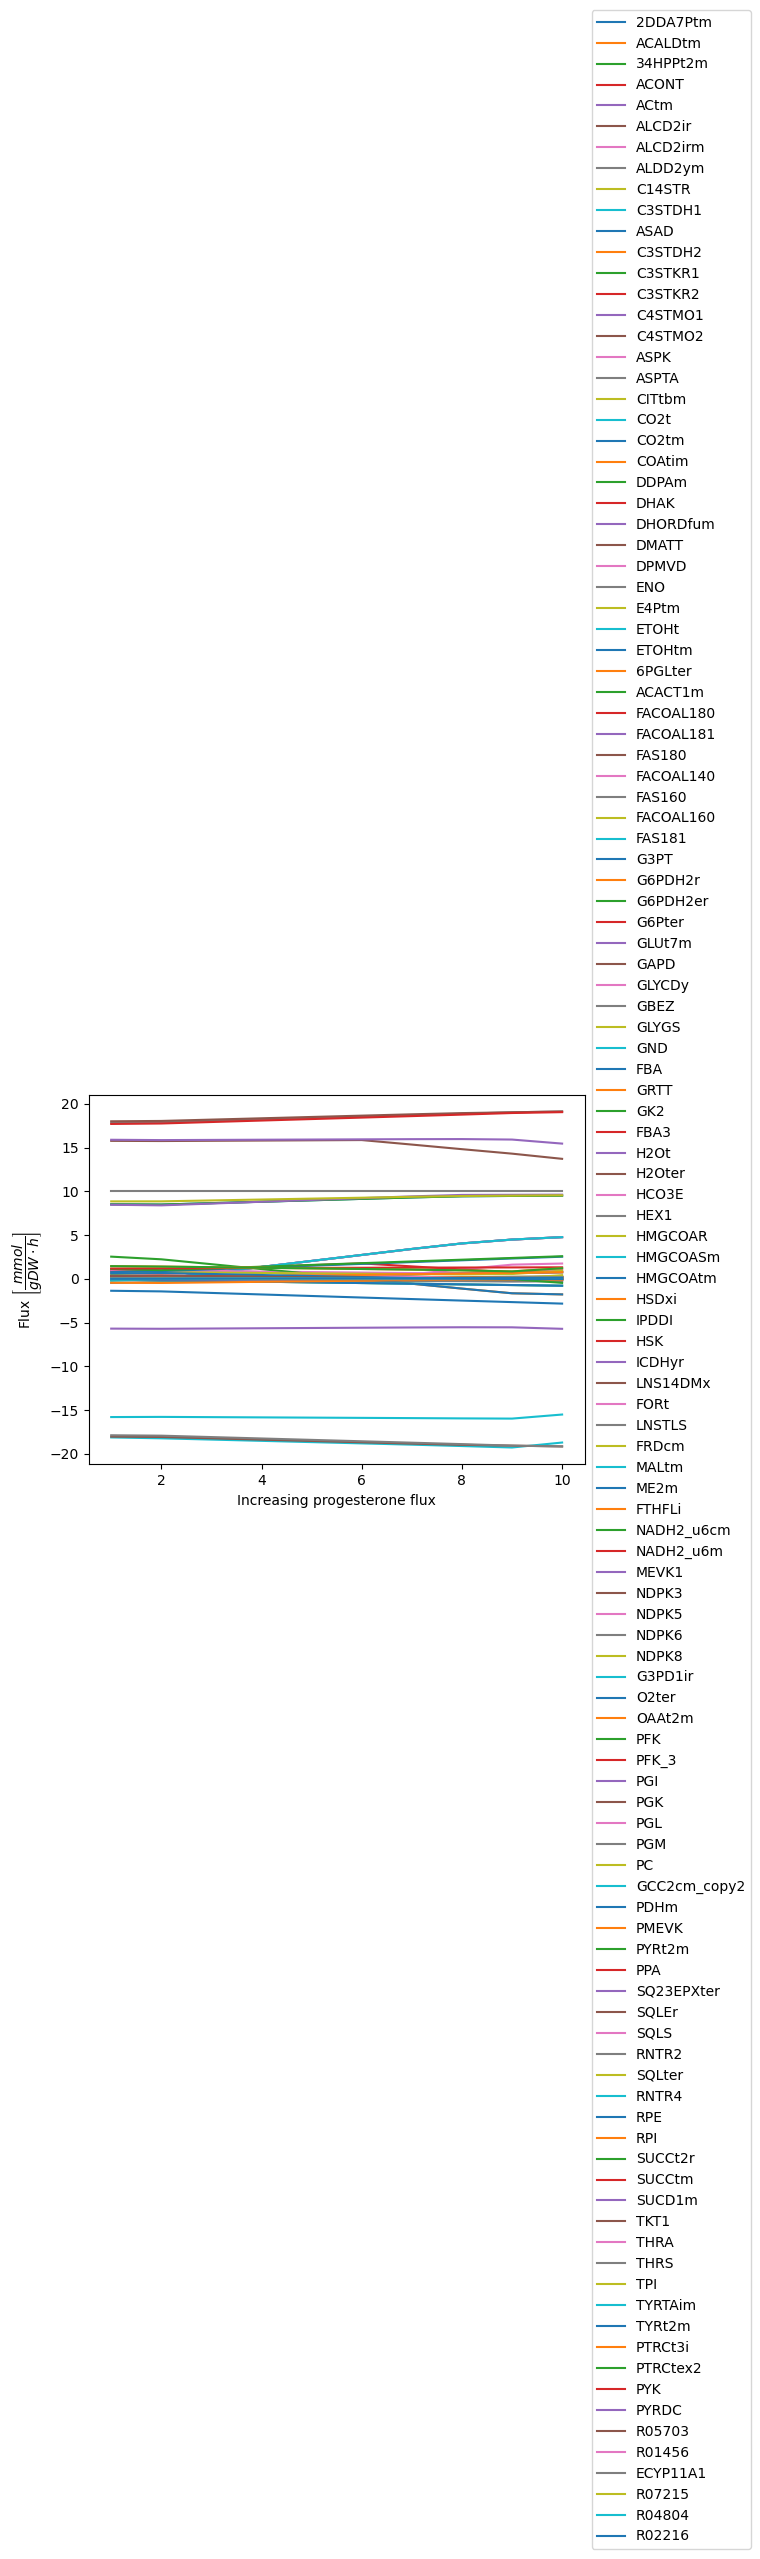

In [89]:
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Increasing progesterone flux");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");
plt.show()

In [ ]:
# sorting the dataframe
df = df.sort_values([1], ascending = False)
df

,1,2,3,4,5,6,7,8,9,10
GAPD,18.018990,18.057998,18.209506,18.361014,18.512523,18.664031,18.815539,18.954090,19.045735,19.137381
ENO,17.860953,17.906662,18.067056,18.227450,18.387845,18.548239,18.708633,18.872678,19.045735,19.137381
PYK,17.714364,17.766288,17.934924,18.103561,18.272198,18.440835,18.609471,18.781839,18.963510,19.063770
PYRDC,15.907336,15.868990,15.890425,15.911860,15.933295,15.954729,15.976164,15.985631,15.930778,15.468864
ALCD2ir,15.781546,15.762371,15.790066,15.817761,15.845457,15.873152,15.357660,14.832382,14.320791,13.727789
...,...,...,...,...,...,...,...,...,...,...
H2Ot,-5.674176,-5.692630,-5.662579,-5.632529,-5.602479,-5.572429,-5.542378,-5.518663,-5.526279,-5.696719
ETOHt,-15.781546,-15.762371,-15.790066,-15.817761,-15.845457,-15.873152,-15.900847,-15.933157,-15.956971,-15.492314
PGM,-17.860953,-17.906662,-18.067056,-18.227450,-18.387845,-18.548239,-18.708633,-18.872678,-19.045735,-19.137381
PGK,-18.018990,-18.057998,-18.209506,-18.361014,-18.512523,-18.664031,-18.815539,-18.954090,-19.045735,-19.137381


In [ ]:
upper = 15
lower = -15

In [ ]:


df.reset_index()
df_significant = pd.DataFrame()
for index, row in df.iterrows():
    print(row)
    if row!=approx(0):
        df_significant.append(row).all(axis=1)
print(df_significant)

1     18.018990
2     18.057998
3     18.209506
4     18.361014
5     18.512523
6     18.664031
7     18.815539
8     18.954090
9     19.045735
10    19.137381
Name: GAPD, dtype: float64


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# sorting the dataframe
df = df.sort_values([1], ascending = False)

# removing genes from dataframe
significant_flux_change = (df>3).all(axis=1) or (df<3).all(axis=1)
print(significant_flux_change)
df = df.loc[significant_flux_change]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [96]:
# sorting the dataframe
df = df.sort_values([1], ascending = False)
print(df.shape[0])
# removing genes from dataframe
# significant_flux_change = (df != approx(0.0)).all(axis=1)
lmt = 3
significant_flux_change = ((df > lmt) | (df < -lmt)).all(axis=1)
# print(significant_flux_change)
# significant_flux_change.sum()
df = df.loc[significant_flux_change]
df
# df.shape

15


,1,2,3,4,5,6,7,8,9,10
GAPD,18.018990,18.057998,18.209506,18.361014,18.512523,18.664031,18.815539,18.954090,19.045735,19.137381
ENO,17.860953,17.906662,18.067056,18.227450,18.387845,18.548239,18.708633,18.872678,19.045735,19.137381
PYK,17.714364,17.766288,17.934924,18.103561,18.272198,18.440835,18.609471,18.781839,18.963510,19.063770
PYRDC,15.907336,15.868990,15.890425,15.911860,15.933295,15.954729,15.976164,15.985631,15.930778,15.468864
ALCD2ir,15.781546,15.762371,15.790066,15.817761,15.845457,15.873152,15.357660,14.832382,14.320791,13.727789
HEX1,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
TPI,8.866319,8.869403,8.973267,9.077132,9.180997,9.284862,9.388726,9.479168,9.521021,9.562874
FBA,8.528249,8.500683,8.663677,8.826672,8.989666,9.152660,9.315654,9.451365,9.488318,9.525270
PFK,8.528249,8.500683,8.663677,8.826672,8.989666,9.152660,9.315654,9.451365,9.488318,9.525270
PGI,8.480666,8.410136,8.615926,8.821716,9.027506,9.233296,9.439086,9.603574,9.618556,9.633537


In [93]:
df.plot

Text(0.5, 1.0, 'Flux scanning based on Enforced Objective Flux')

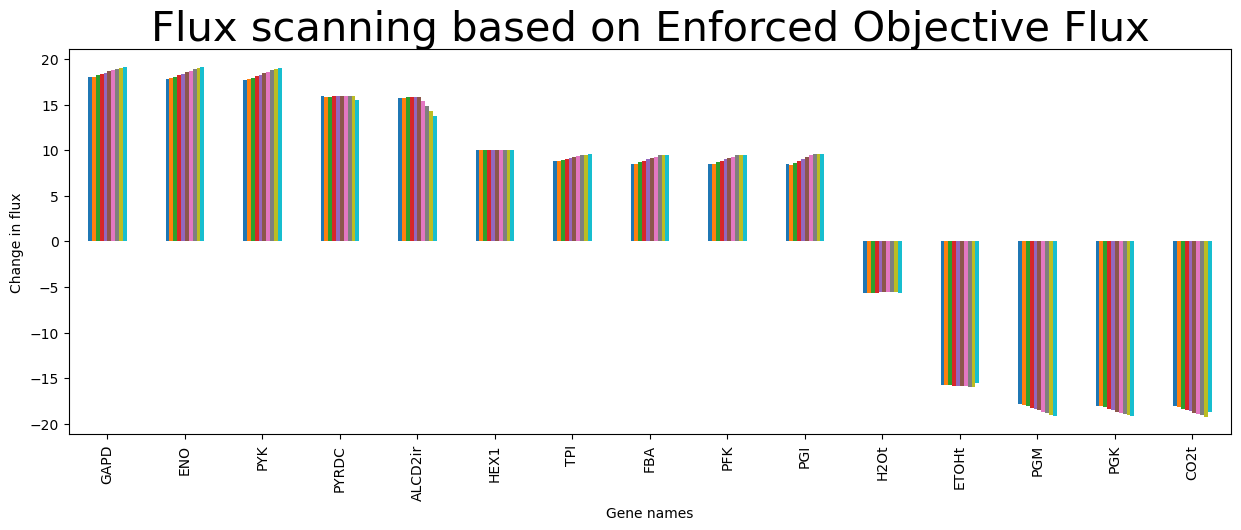

In [99]:
#def bar_color(df,color1,color2):
#    return np.where(df.values >=0,color1,color2).T
# fig = df.plot(legend=None, kind='bar', color=bar_color(df,'salmon','blue'),figsize=(15, 5), grid =False);

fig = df.plot(legend=None, kind='bar', figsize=(15, 5), grid =False);
fig.set_ylabel('Change in flux')
fig.set_xlabel('Gene names')
fig.set_title('Flux scanning based on Enforced Objective Flux', size=30)

Text(0.5, 1.0, 'Reactions with a relative change in Flux > 80%')

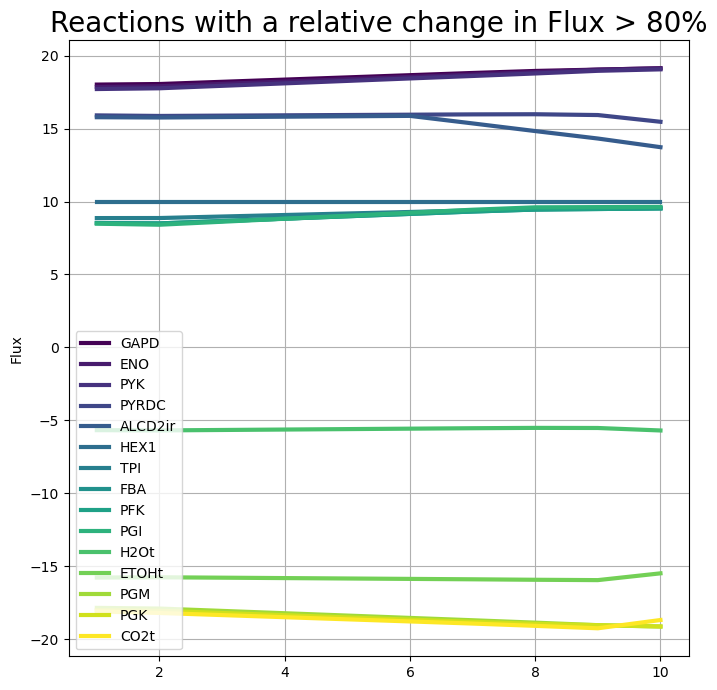

In [98]:
fig = df.T.plot(cmap="viridis",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux')
fig.set_title('Reactions with a relative change in Flux > 80%', size=20)

In [10]:
for i in df[1]:
    print(i)

-0.073295
-0.051995
0.0
0.173048
-0.051995
15.781546
0.0
0.051995
0.013467
0.013467
-0.120577
0.013467
0.013467
0.013467
0.013467
0.013467
0.120577
-0.455238
-0.073295
-18.108191
-1.349127
0.080803
0.073295
0.0
0.030671
0.026934
0.080803
17.860953
0.073295
-15.781546
0.0
-0.013661
0.080803
0.000776
0.005125
0.000776
-0.012734
0.012734
0.006833
0.005125
0.0
1.032738
0.013661
0.013661
0.0
18.01899
0.0
0.143788
0.143788
1.0464
8.528249
0.026934
0.00094
0.34492
-5.674176
-0.013467
0.729978
10.0
-0.080803
-0.080803
-0.080803
0.120577
0.026934
0.104687
0.158597
0.013467
-0.014291
0.013467
0.0
-0.222525
0.0
0.0
2.550693
0.935621
0.080803
-0.007543
-0.000666
-0.001664
0.00094
0.00685
0.013467
0.2855
8.528249
0.34492
8.480666
-18.01899
1.0464
-17.860953
0.544481
0.07765
0.778604
0.080803
1.14319
1.190418
0.013467
0.013467
0.013467
0.000666
0.013467
0.001664
0.616546
-0.429305
0.0
0.045122
0.122772
0.34492
0.0
0.104687
8.866319
0.0
0.0
1.464088
1.464088
17.714364
15.907336
0.012857
0.012857
0.01

### References
Jiang, Yi-qi, and Jian-ping Lin. "Recent progress in strategies for steroid production in yeasts." World Journal of Microbiology and Biotechnology 38.6 (2022): 1-14.

Jordá, Tania, and Sergi Puig. "Regulation of ergosterol biosynthesis in Saccharomyces cerevisiae." Genes 11.7 (2020): 795.